# AGH Modelling of Physical Systems Lab 6 (2025 April 15th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl) & Emma Ware (ecware@ucdavis.edu) 

**0. Key concepts:**
- [Coagulation](https://en.wikipedia.org/wiki/Coagulation_(disambiguation)) - growth of particles through aggregation
- [Smoluchowski coagulation equation (SCE)](https://en.wikipedia.org/wiki/Smoluchowski_coagulation_equation) - deterministic mathematical model
- [Golovin's analytic solution to SCE](http://mi.mathnet.ru/dan27630) for additive kernel and exponential initial condition
- [Super-Droplet Method Monte-Carlo algorithm](https://arxiv.org/abs/physics/0701103) by Shima et al. 2007 ([patent in 2006](https://patents.google.com/patent/EP1847939A3))

**1. particle-resolved random-sampled state representation for a mass-controled coagulation problem**

In [39]:
""" targetting 100% nbqa-pylint clean code! :) """

from types import SimpleNamespace
from functools import partial
import numpy as np
import scipy
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [40]:
PARAMS_PHYS = SimpleNamespace(
    n0=2**23,
    dv_m3 = 1e6,
    x0_kg=1.192e-13,
    b_per_s = 1500,
)
PARAMS_PHYS.dist = scipy.stats.expon(loc=0, scale=PARAMS_PHYS.x0_kg)
PARAMS_PHYS.norm = PARAMS_PHYS.n0 * PARAMS_PHYS.dv_m3

PARAMS_COMP = SimpleNamespace(
    n_part = 2**11,
    t_max_s = 3600,
    n_step = 1800,
)
PARAMS_COMP.dt_s = PARAMS_COMP.t_max_s / PARAMS_COMP.n_step

PARAMS_BINS = SimpleNamespace(
    min_x = -12,
    max_x = -5,
    count = 70
)

RNG = np.random.default_rng(seed=44)

In [41]:
def sample(*, params_comp, params_phys, rng):
    """ randomly samples a particle population using constant-multiplicity,
    uniform-mass and uniform-log-mass schemes and returns a dictionary
    of three simulation state, each composed of 'mass' and 'mult' arrays """
    u01 = rng.uniform(0, 1, size=params_comp.n_part)
    uniform_sampling_range = [params_phys.dist.ppf(q) for q in (.001, .999)]
    x_uniform_linx = (
        uniform_sampling_range[0]
        + u01 * (uniform_sampling_range[1] - uniform_sampling_range[0])
    )
    x_uniform_logx = np.exp(
        np.log(uniform_sampling_range[0])
        + u01 * (np.log(uniform_sampling_range[1]) - np.log(uniform_sampling_range[0]))
    )
    return {
        k: {
            'mass': v['x'],
            'mult': np.round(v['y'] * params_phys.norm).astype(int),
        }
        for k,v in
        {
            'sampling: uniform random in x': {
                'x': x_uniform_linx,
                'y': params_phys.dist.pdf(x_uniform_linx) \
                  * (uniform_sampling_range[1] - uniform_sampling_range[0]) \
                  / params_comp.n_part,
            },
            'sampling: uniform random in ln(x)': {
                'x': x_uniform_logx,
                'y': params_phys.dist.pdf(x_uniform_logx) \
                  * (np.log(uniform_sampling_range[1]) - np.log(uniform_sampling_range[0])) \
                  / (params_comp.n_part / x_uniform_logx),
            },
            'sampling: constant multiplicity': {
                'x': params_phys.dist.ppf(u01),
                'y': np.full(shape=params_comp.n_part, fill_value=1 / params_comp.n_part),
            }
        }.items()
    }

PARTICLES = sample(params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)

In [42]:
def x_of_mass(mass):
    """ defines the plot x coordinate as a funciton of particle mass """
    return np.log(mass) / 3

def mass_of_x(coord):
    """ computes mass back from the plot x coordinate """
    return np.exp(3 * coord)

def kernel(mass_1, mass_2, coeff):
    """ additive coagulation kernel """
    return coeff * (mass_1 + mass_2)

def analytic_solution(mass_kg, time_s, params_phys):
    """ Golovin's analytic solution to Smoluchowski coagulation equation 
    for additive kernel and exponential initial condition """
    tau = 1 - np.exp(-params_phys.n0 * params_phys.b_per_s * params_phys.x0_kg * time_s)
    sqrt_tau = np.sqrt(tau)
    return (
        (1 - tau) / (mass_kg * sqrt_tau)
        * scipy.special.ive(1, 2 * mass_kg / params_phys.x0_kg * sqrt_tau)  # pylint: disable=no-member
        * np.exp(-(1 + tau - 2 * sqrt_tau) * mass_kg / params_phys.x0_kg)
    )

In [43]:
def plot(*, particles, params_phys, params_comp, params_bins, rng, time=0):
    """ plots the particle state as both a histogram as well as population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    _, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(11, 6),
        sharex=True,
        tight_layout=True,
    )
    scale = params_phys.norm / params_comp.n_part
    for k in particles:
        axs['hist'].hist(
            x=x_of_mass(particles[k]['mass']),
            weights=particles[k]['mult'] / params_phys.norm * particles[k]['mass'],
            bins=params_bins.count,
            range=(params_bins.min_x, params_bins.max_x),
            label=f'{k}',
            alpha=.666,
            density=True,
        )
        axs['part'].scatter(
            x_of_mass(particles[k]['mass']),
            rng.uniform(0, 1, params_comp.n_part),
            s=.25 + 2 * particles[k]['mult'] / scale
        )
    lin_x, d_x = np.linspace(params_bins.min_x, params_bins.max_x, 256, retstep=True)
    x_mean = lin_x[:-1] + d_x / 2
    m_mean = mass_of_x(x_mean)
    dn_dm = analytic_solution(mass_kg=m_mean, time_s=time, params_phys=params_phys)
    axs['hist'].plot(
        x_mean,
        dn_dm * np.diff(mass_of_x(lin_x)) / np.diff(lin_x) * params_phys.norm * m_mean,
        color='black',
        label='Golovin solution'
    )
    axs['hist'].legend()
    axs['hist'].set_ylabel(r'pdf(x) $\cdot$ mass(x)')
    axs['hist'].set_title(f'time: {time:.1f} s')
    axs['hist'].set_xlim(params_bins.min_x, params_bins.max_x)
    axs['part'].set_xlabel(r'$x = ln(\sqrt[3]{m})$')
    axs['part'].set_yticks([])
    axs['part'].set_ylim(0,1)
    for axes in axs.values():
        axes.grid()
    show_plot()

In [44]:
plot(
    particles=PARTICLES,
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_bins=PARAMS_BINS,
    rng=RNG,
    time=1e-5
)

**2. Monte-Carlo representation of coagulation dynamics**

In [45]:
from concurrent.futures import ThreadPoolExecutor

def sdm_parallel(*, pairs, u01, mult, mass, kern, dt, dv):
    """Parallel-safe version of SDM using thread-safe staged updates."""
    n = len(mult)
    num_pairs = len(pairs)

    updates = []

    def evaluate(alpha_jk):
        alpha, (j, k) = alpha_jk
        if mult[k] > mult[j]:
            j, k = k, j

        rate = kern(mass[j], mass[k])
        p = rate * (dt / dv) * mult[j] * n * (n - 1) / (2 * num_pairs)

        if p > u01[alpha]:
            return j, k
        return None

    # Run the evaluation in parallel
    with ThreadPoolExecutor() as executor:
        for result in executor.map(evaluate, enumerate(pairs)):
            if result is not None:
                updates.append(result)

    # Apply updates sequentially
    for j, k in updates:
        if mult[j] != mult[k]:
            mult[j] -= mult[k]
            mass[k] += mass[j]
        else:
            mass[k] += mass[j]
            mass[j] = mass[k]
            mult[j] = mult[k] // 2
            mult[k] -= mult[j]


In [47]:
def simulate(*, params_phys, params_comp, particles, rng):
    """ does simulation for all sampling variants (each variant using the same shuffled numbers) """
    n_pairs = params_comp.n_part // 2
    kern = partial(kernel, coeff=params_phys.b_per_s)
    for _ in range(params_comp.n_step):
        non_overlapping_pairs = rng.permutation(params_comp.n_part)[: 2 * n_pairs].reshape(-1, 2)
        u01 = rng.uniform(0, 1, n_pairs)
        for part in particles.values():
            sdm_parallel(
                pairs=non_overlapping_pairs,
                u01=u01,
                kern=kern,
                dt=params_comp.dt_s,
                dv=params_phys.dv_m3,
                **part
            )

simulate(particles=PARTICLES, params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)

KeyboardInterrupt: 

C:\Users\Joanna\Documents\coding\MPS\MPS\.venv\Lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\Joanna\Documents\coding\MPS\MPS\.venv\Lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


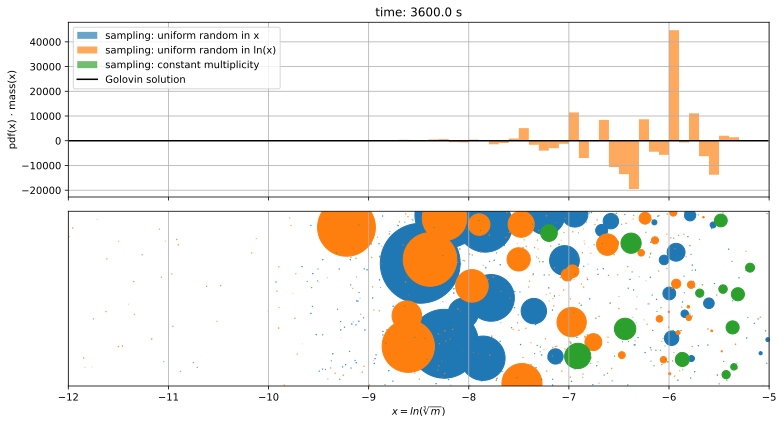

In [30]:
plot(
    particles=PARTICLES,
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_bins=PARAMS_BINS,
    rng=RNG,
    time=PARAMS_COMP.t_max_s,
)